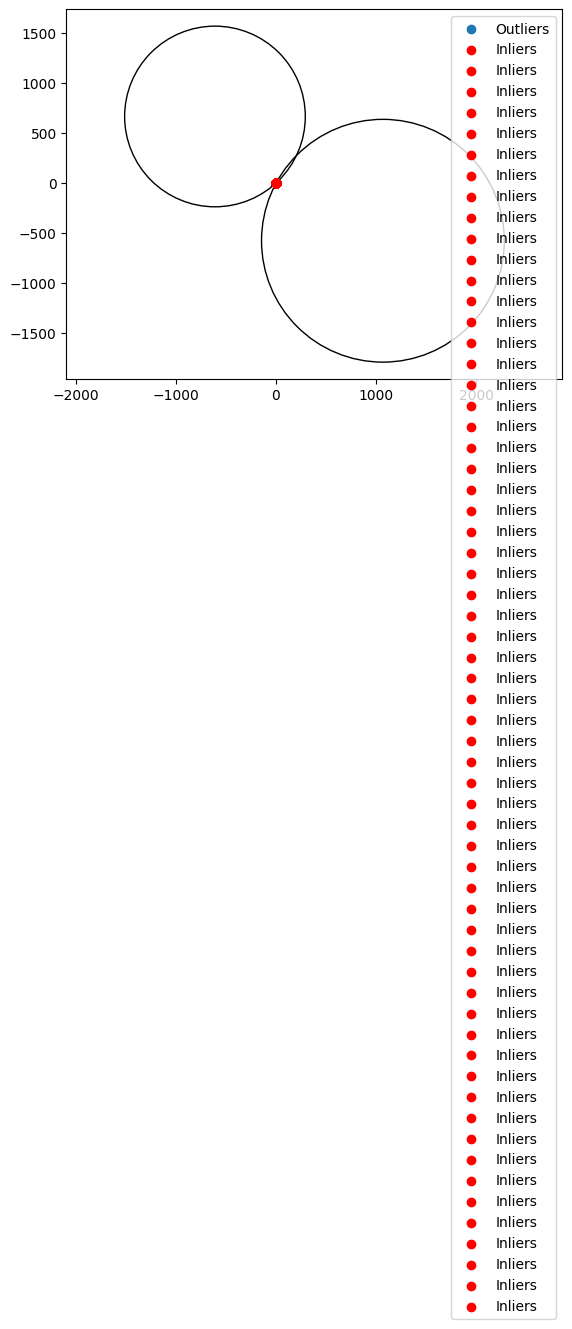

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Load the data
data = np.load("circles.npy")

# Parameters
T = 100  # Number of RANSAC iterations
epsilon = 0.1  # Inlier distance threshold
min_inliers = 10  # Minimum number of inliers for optimization

# Function to calculate the squared Euclidean distances between a circle and its inliers
def circle_residuals(params, data):
    cx, cy, r = params
    distances = np.sqrt((data[:, 0] - cx) ** 2 + (data[:, 1] - cy) ** 2)
    return distances - r

# Function to fit a circle using RANSAC and then optimize it with least squares
def fit_circle(data, epsilon):
    # Initialize variables for the best circle
    best_circle = None
    best_inliers = []

    # Perform RANSAC iterations
    for _ in range(T):
        # Randomly choose 3 points
        indices = np.random.choice(len(data), 3, replace=False)
        points = data[indices]

        # Fit the circle using circumcircle formula
        cx, cy, r = circumcircle(*points)

        # Classify inliers
        distances = np.sqrt((data[:, 0] - cx) ** 2 + (data[:, 1] - cy) ** 2)
        inliers = data[distances < epsilon]

        # Update best circle if the current circle has more inliers
        if len(inliers) > len(best_inliers):
            best_circle = (cx, cy, r)
            best_inliers = inliers

    # Check if enough inliers for optimization
    if len(best_inliers) >= min_inliers:
        # Optimize the best circle using least squares
        initial_params = best_circle
        optimized_params = least_squares(circle_residuals, initial_params, args=(best_inliers,), method='lm').x
        return optimized_params, best_inliers
    else:
        return best_circle, best_inliers

# Perform circle fitting using RANSAC and least squares optimization
optimized_circles = []
for _ in range(T):
    optimized_params, inliers = fit_circle(data, epsilon)
    optimized_circles.append((optimized_params, inliers))
    data = data[~np.isin(data, inliers).all(1)]  # Remove inliers for the next iteration

# Plot the original data
plt.scatter(data[:, 0], data[:, 1], label='Outliers')

# Plot the fitted circles
for circle_params, inliers in optimized_circles:
    if circle_params is not None:
        cx, cy, r = circle_params
        circle = plt.Circle((cx, cy), radius=r, fill=False)
        plt.gca().add_patch(circle)
        plt.scatter(inliers[:, 0], inliers[:, 1], color='red', label='Inliers')

plt.axis('equal')
plt.legend()
plt.show()
